In [1]:
%cd ..

/home/ec2-user/uclresearchanalysis


In [2]:
%matplotlib inline
import builtins
builtins.uclresearch_topic = 'GIVENCHY' #0 -- Finished
# builtins.uclresearch_topic = 'HAWKING' #0 -- Finished
# builtins.uclresearch_topic = 'NYC' # 88001
# builtins.uclresearch_topic = 'FLORIDA' # 448387
from configuration import config
from configuration.config import load_ml_data
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from pandas import *
import pandas as pd
from pprint import pprint
import sys
import numpy as np
import matplotlib.pyplot as plt

('Reading config file from location: '
 '/home/ec2-user/uclresearchanalysis/configuration/env.properties')
{'calculate': {'analysis': True,
               'network': True,
               'uniquetweets': True,
               'uniqueusers': True},
 'data': {'dates': ['2018-03-11', '2018-03-12', '2018-03-13'],
          'eventname': "Givenchy's Death",
          'phrases': ['givenchy%20death', 'givenchy%20passed%20away'],
          'starttime': 'Mar 12 08:20:00 -0500 2018'},
 'path': {'crawl': {'followers': '/home/ec2-user/uclresearchanalysis/followers',
                    'friends': '/home/ec2-user/uclresearchanalysis/friends'},
          'cwd': '/home/ec2-user/uclresearchanalysis/data/givenchy',
          'ml': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle',
          'networkx': {'all': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_all.dat',
                       'friends': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_friends.dat',


In [3]:
# Parameters
interval = 15

# 1. Prepare
def prepare_data(interval):
    df = load_ml_data(interval)
    df = df.reset_index(drop=True)
    
    # Converting all type to float, to prepare for feature selection
    df = df.astype('float')
    # Reset index, with drop equals to true to avoid setting old index as a new column
    df = df.reset_index(drop=True)
    # Visualize distribution
    print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
        df['label'].value_counts()[0],
        df['label'].value_counts()[1]
    ))
    df.groupby(['TwM_tCurrent','label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')
    
    columns = list(df.columns)
    columns.remove('label')
    
    X = df[columns]
    y = df[['label']]
    return df, X, y


Loading data file from path /home/ec2-user/uclresearchanalysis/data/givenchy/pickle/15_data.dat
'Loaded 94933 entires'
[Original] data counts, with uninfected (0): 90027, infected (1): 4906


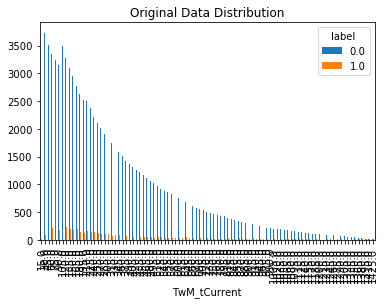

In [4]:
# 1. Prepare
df, X, y = prepare_data(interval)

In [5]:
len(X.columns)

62

In [6]:
def train(df, X, y, model, n_folds, is_xgb):
    # 2. N Fold Split
    # Stratified K-Folds cross-validator
    # Provides train/test indices to split data in train/test sets. 
    # This cross-validation object is a variation of KFold that returns stratified folds. 
    # The folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    corrDataframe = pd.DataFrame()    
    mse = []
    acc = []
    roc = []
    F1 = []
    auc = []
    auc_t = []
    acc_t = []
    fold_count = 0
    t_current = 210
#     number_of_features = len(X.columns)
    number_of_features = 5

    print("Start cross validation")
    for train, test in skf.split(X, y):
        print("===Processing fold %s===" % fold_count)
        train_fold = df.loc[train]
        test_fold = df.loc[test]

        # 3. Rebalance (Up-sampling)
        diff = sum(train_fold.label == 0) - sum(train_fold.label == 1)
        append_indices = np.random.choice(train_fold[train_fold.label == 1].index, diff, replace=True)
        new_sample = train_fold.loc[append_indices,:]
        train_fold = pd.concat([train_fold, new_sample])
        train_fold = train_fold.reset_index(drop=True)
        print('[Up-sampling] data counts, with uninfected (0): {}, infected (1): {}'.format(
            train_fold['label'].value_counts()[0],
            train_fold['label'].value_counts()[1],
        ))
        
        # 4. Feature Selection
        corr = train_fold.corr()['label'][train_fold.corr()['label'] < 1].abs()
        corr = corr.sort_values(ascending=False)
        corrDataframe = corrDataframe.append(pd.DataFrame(corr.rename('cv{}'.format(fold_count))).T)

        features = corr.index[range(number_of_features)].values
#         train_fold_input  = SelectKBest(chi2, k=50).fit_transform(train_fold[X.columns], train_fold['label'])

        train_fold_input = train_fold[features]
        train_fold_output = train_fold['label']
        
        # 5. Training
        # Fit logistic regression
        if is_xgb:
            xgtrain = xgb.DMatrix(train_fold_input.values, train_fold_output.values)
#             evallist = [(xgtest, 'eval'), (xgtrain, 'train')]
            evallist = [(xgtrain, 'train')]
            bst = xgb.train(model, xgtrain, 50, evallist)
        else:
            model.fit(train_fold_input, train_fold_output)

        # 6. Testing
        # Check MSE on test set
        test_fold_t = test_fold[test_fold.TwM_tCurrent == t_current]
        if is_xgb:
            xgtest = xgb.DMatrix(test_fold[features].values)
            xgtest_t = xgb.DMatrix(test_fold_t[features].values)
            pred = bst.predict(xgtest)
            pred_t = bst.predict(xgtest_t)
        else:
            pred = model.predict(test_fold[features])
            pred_t = model.predict(test_fold_t[features])
        mse.append(mean_squared_error(test_fold.label, pred))
        roc.append(roc_auc_score(test_fold.label, pred))
        auc_t.append(roc_auc_score(test_fold_t.label, pred_t))

        acc.append(accuracy_score(test_fold.label, (pred>0.5).astype(int)))
        acc_t.append(accuracy_score(test_fold_t.label, (pred_t>0.5).astype(int)))
        F1.append(f1_score(test_fold.label,(pred>0.5).astype(int)))
        cm = confusion_matrix(test_fold.label, (pred>0.5).astype(int))
        print(cm)

        # Done with the fold
        fold_count += 1
    print("Finished cross validation")
    print("MSE: {} ".format(DataFrame(mse).mean()))
    print("ACC: {} ".format(DataFrame(acc).mean()))
    print("AUC: {} ".format(DataFrame(roc).mean()))
#     print("F1: {} ".format(DataFrame(F1).mean()))
    print("ACC for t at {}: {} ".format(t_current, DataFrame(acc_t).mean()))
    corrDataframe = corrDataframe.T
    corrDataframe['average corr'] = corrDataframe.mean(numeric_only=True, axis=1)
    print(corrDataframe.sort_values(by=['average corr'], ascending=False).to_string())
    if is_xgb:
        return bst
    return model

In [7]:
#xgboost
param = {'max_depth': 3, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 12
param['eval_metric'] = ['auc']

xgb_model = train(df, X, y, param, 10, 1)

Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024
[0]	train-auc:0.761035
[1]	train-auc:0.771615
[2]	train-auc:0.782596
[3]	train-auc:0.785523
[4]	train-auc:0.786554
[5]	train-auc:0.788974
[6]	train-auc:0.790537
[7]	train-auc:0.792468
[8]	train-auc:0.792599
[9]	train-auc:0.793544
[10]	train-auc:0.794872
[11]	train-auc:0.79592
[12]	train-auc:0.79793
[13]	train-auc:0.798699
[14]	train-auc:0.799143
[15]	train-auc:0.79999
[16]	train-auc:0.801223
[17]	train-auc:0.801395
[18]	train-auc:0.801726
[19]	train-auc:0.803515
[20]	train-auc:0.803561
[21]	train-auc:0.804187
[22]	train-auc:0.804264
[23]	train-auc:0.80476
[24]	train-auc:0.804958
[25]	train-auc:0.805963
[26]	train-auc:0.806181
[27]	train-auc:0.806919
[28]	train-auc:0.807116
[29]	train-auc:0.80833
[30]	train-auc:0.80965
[31]	train-auc:0.809967
[32]	train-auc:0.810374
[33]	train-auc:0.811343
[34]	train-auc:0.812158
[35]	train-auc:0.812586
[36]	train-auc:0.813166
[37]	t

/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[18]	train-auc:0.802308
[19]	train-auc:0.802567
[20]	train-auc:0.803869
[21]	train-auc:0.804767
[22]	train-auc:0.805172
[23]	train-auc:0.805266
[24]	train-auc:0.805596
[25]	train-auc:0.80633
[26]	train-auc:0.806897
[27]	train-auc:0.807499
[28]	train-auc:0.807707
[29]	train-auc:0.808191
[30]	train-auc:0.808342
[31]	train-auc:0.808415
[32]	train-auc:0.80844
[33]	train-auc:0.809415
[34]	train-auc:0.809473
[35]	train-auc:0.810009
[36]	train-auc:0.810617
[37]	train-auc:0.810963
[38]	train-auc:0.811274
[39]	train-auc:0.811799
[40]	train-auc:0.811952
[41]	train-auc:0.812063
[42]	train-auc:0.81259
[43]	train-auc:0.812669
[44]	train-auc:0.813245
[45]	train-auc:0.813725
[46]	train-auc:0.813846
[47]	train-auc:0.814014
[48]	train-auc:0.814161
[49]	train-auc:0.814518
[[6972 2031]
 [ 156  335]]
===Processing fold 2===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024
[0]	train-auc:0.762886
[1]	train-auc:0.773872
[2]	train-auc:0.780841
[3]	train-auc:0.787367
[4]	train-auc:0.7

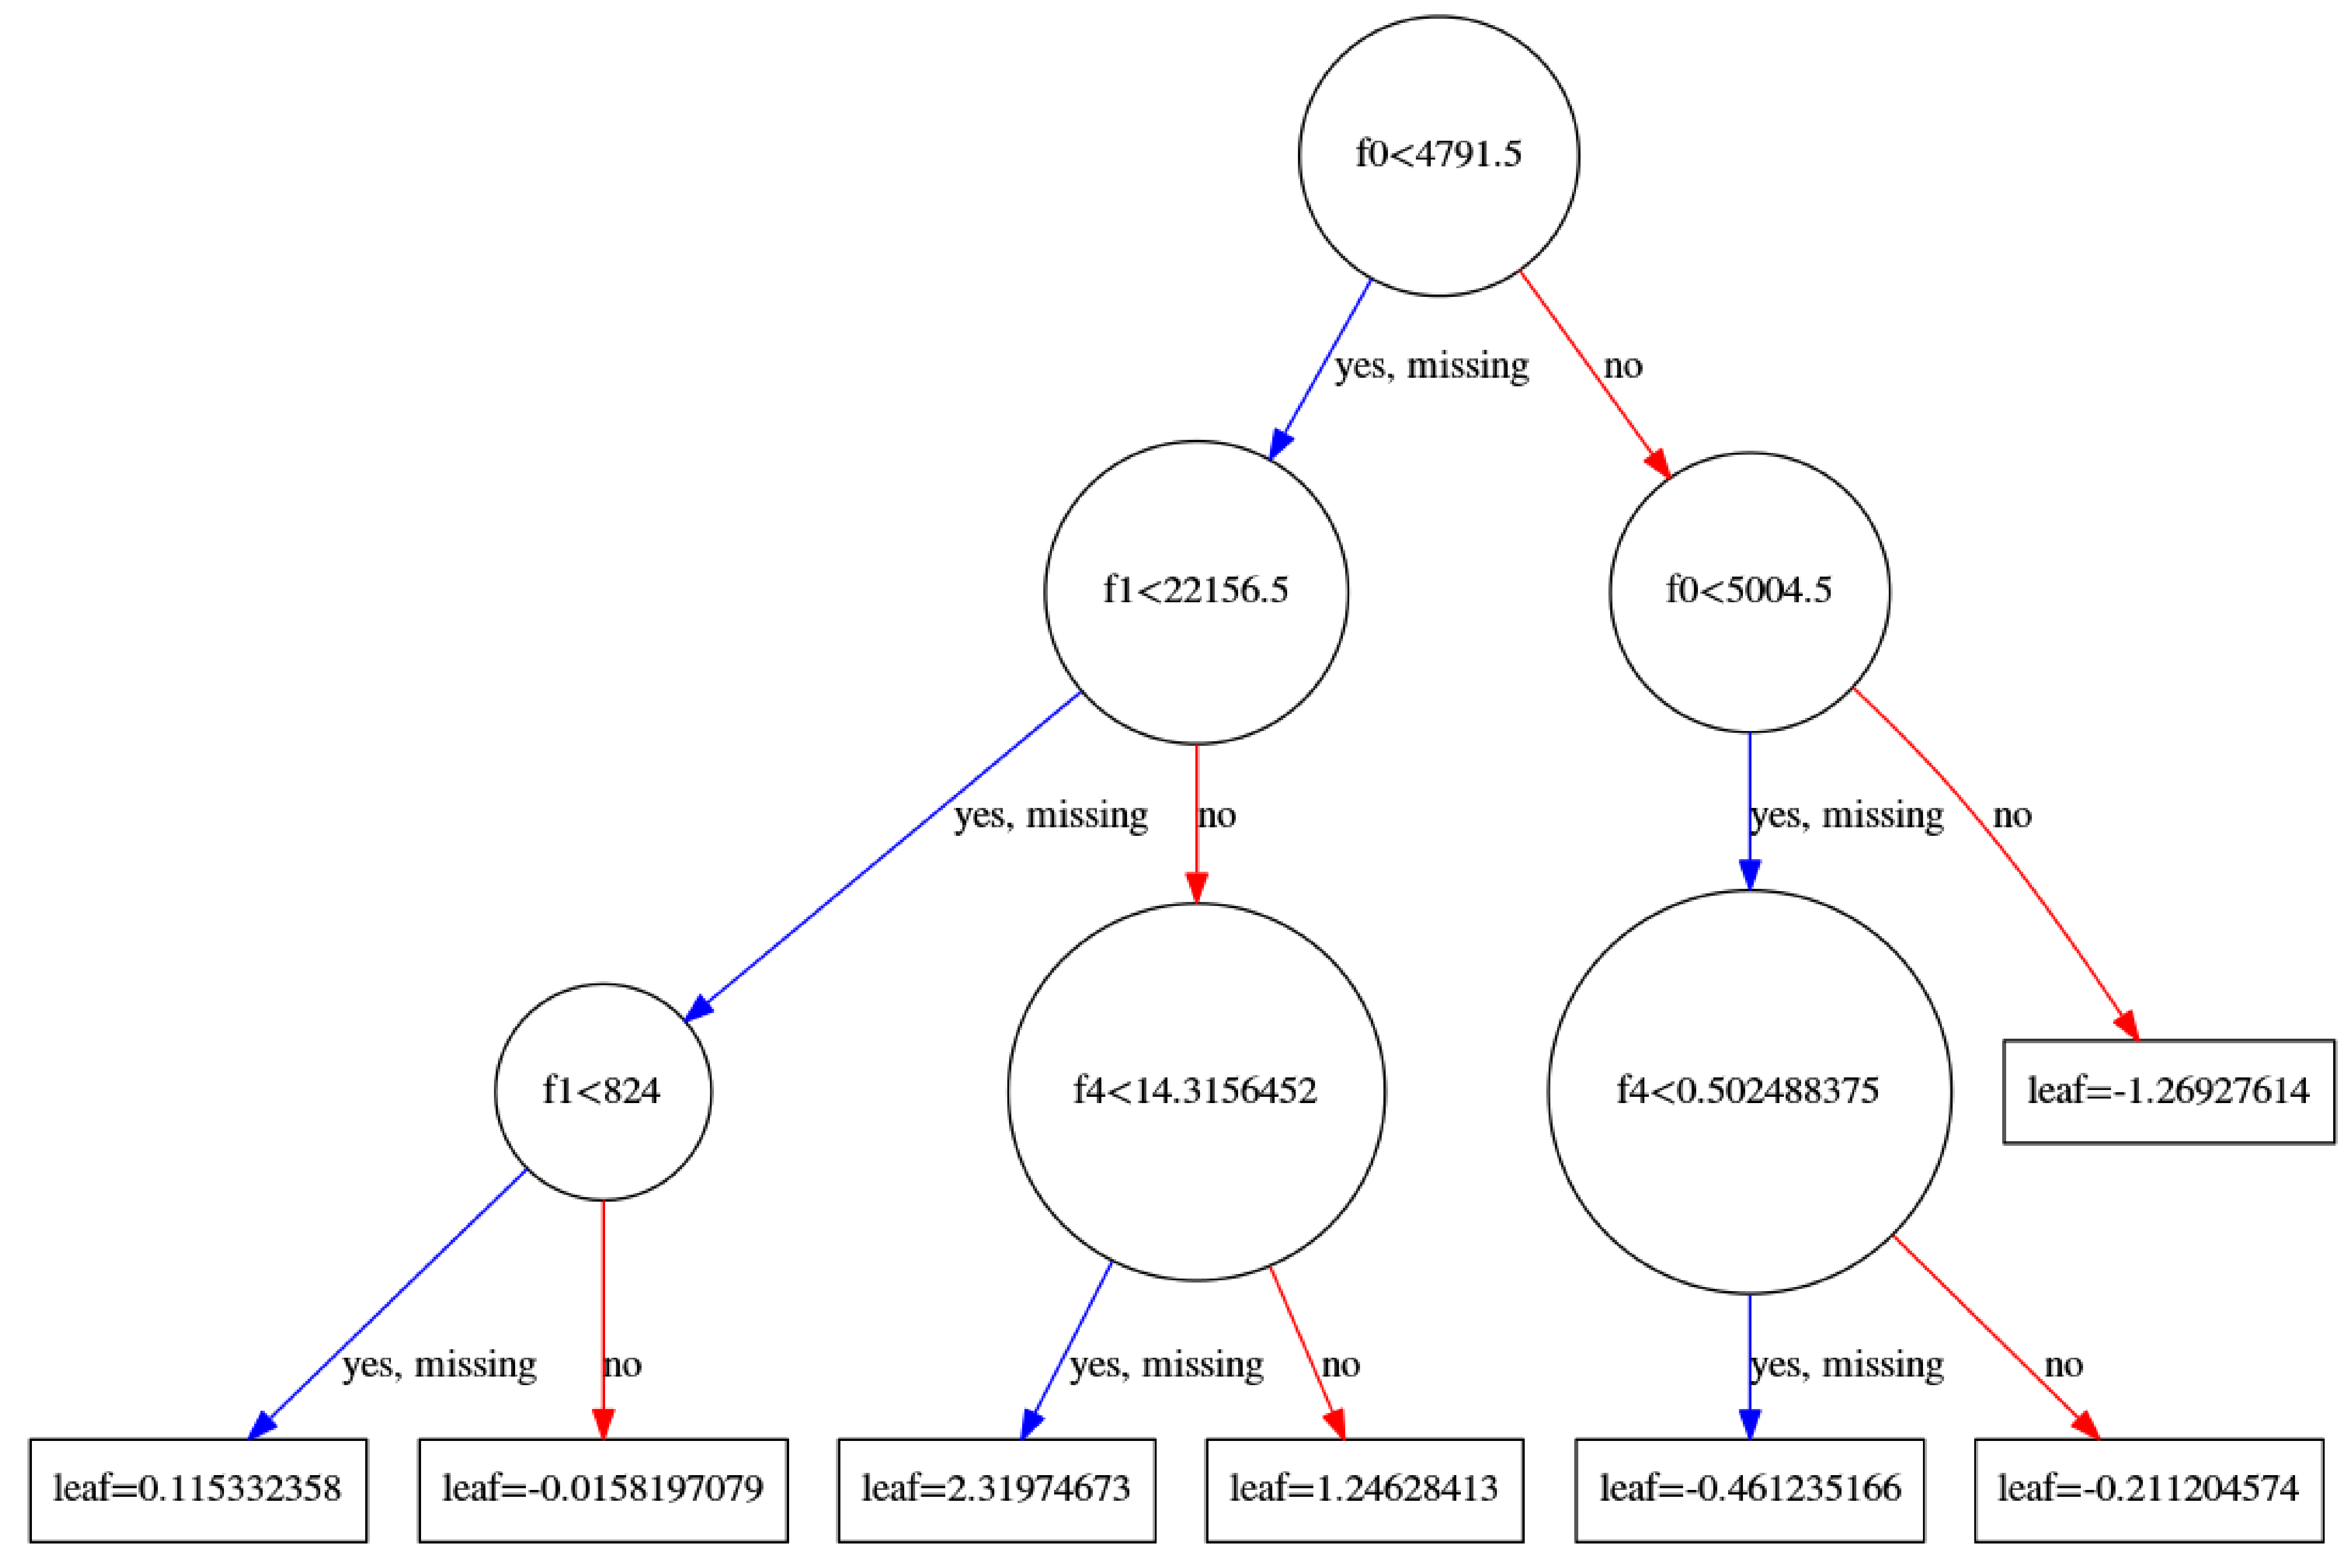

In [13]:
import matplotlib.pyplot as plt

xgb.plot_tree(xgb_model, num_trees=1)

fig = plt.gcf()
fig.set_size_inches(100, 50)
plt.show()

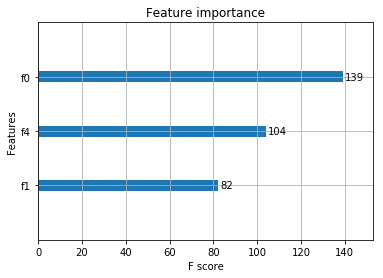

In [9]:
xgb.plot_importance(xgb_model)
fig = plt.gcf()
# fig.set_size_inches(50, 100)
plt.show()

In [10]:
# Naive Bayes
train(df, X, y, GaussianNB(), 10, 0)

Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024
[[6956 2047]
 [ 166  325]]
===Processing fold 1===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[6925 2078]
 [ 178  313]]
===Processing fold 2===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024
[[7014 1989]
 [ 194  297]]
===Processing fold 3===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024
[[6815 2188]
 [ 184  307]]
===Processing fold 4===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024
[[7032 1971]
 [ 195  296]]
===Processing fold 5===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024
[[6930 2073]
 [ 170  321]]
===Processing fold 6===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024
[[6977 2026]
 [ 191  299]]
===Processing fold 7===
[Up-sampling] data counts, with uninfected (0): 81025, infected (1): 81025
[[6894 2108]
 [ 190  300]]
===Processing fold 8===
[Up-sampling] data counts, with uninfected (0): 81025, infected (1): 81025
[[6928 2074]
 [ 170  320]]
===Processing fold 9===
[Up-sampling] data counts, with uninfected (0): 81025, infected (1)

GaussianNB(priors=None)

In [11]:
# Logistic Regression
train(df, X, y, LogisticRegression(), 10, 0)


Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024
[[6761 2242]
 [ 152  339]]
===Processing fold 1===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[6894 2109]
 [ 177  314]]
===Processing fold 2===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024
[[6869 2134]
 [ 169  322]]
===Processing fold 3===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024
[[6892 2111]
 [ 181  310]]
===Processing fold 4===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024
[[6896 2107]
 [ 179  312]]
===Processing fold 5===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024
[[6920 2083]
 [ 197  294]]
===Processing fold 6===
[Up-sampling] data counts, with uninfected (0): 81024, infected (1): 81024
[[6832 2171]
 [ 180  310]]
===Processing fold 7===
[Up-sampling] data counts, with uninfected (0): 81025, infected (1): 81025
[[6918 2084]
 [ 175  315]]
===Processing fold 8===
[Up-sampling] data counts, with uninfected (0): 81025, infected (1): 81025
[[6885 2117]
 [ 185  305]]
===Processing fold 9===
[Up-sampling] data counts, with uninfected (0): 81025, infected (1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
# Random Forest 10 folds
rf_10 = train(df, X, y, RandomForestClassifier(n_estimators= 100,min_samples_split=2,
                                  min_samples_leaf=1,random_state=10), 10)

TypeError: train() missing 1 required positional argument: 'is_xgb'

In [ ]:
rf_2 = train(df, X, y, RandomForestClassifier(n_estimators= 100,min_samples_split=2,
                                  min_samples_leaf=1,random_state=10), 2)

In [ ]:
importances=rf_10.feature_importances_

In [ ]:
rf_2.feature_importances_

In [ ]:
plt.figure()
plt.title("Feature importances")
plt.scatter(range(0,60), importances,  color="r")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
# GBDT
train(df, X, y, GradientBoostingClassifier(n_estimators=150, min_samples_split=30,
                                  min_samples_leaf=2,max_depth=12,max_features='sqrt', subsample=0.8,random_state=10), 10)